In [21]:
import distutils.spawn
import math
from matplotlib import rc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from models import FullResNet

In [2]:
sns.set(font_scale=1.5)

if distutils.spawn.find_executable('latex'):
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    rc('text', usetex=True)

In [32]:
def run_experiment(config, grid_beta, grid_depth, niter, dim_input, nb_classes):
    results = []
    for beta in grid_beta:
        for depth in grid_depth:
            print(depth)
            for k in range(niter):
                if niter > 10**3 and k % 10 == 0:
                    print(k)
                model_config = default_config
                model_config['scaling_beta'] = beta
                model_config['depth'] = depth

                x0 = torch.rand((1, dim_input))
                target = torch.rand((1,))
                model = FullResNet(dim_input, nb_classes, **model_config)

                h_0 = model.init(x0)
                h_L = model.forward_hidden_state(h_0)
                output = model.final(h_L)

                h_0.retain_grad()
                h_L.retain_grad()

                # model.train()
                loss = torch.norm(output - target)**2
                loss.backward()

                h_0_grad = h_0.grad
                h_L_grad = h_L.grad

                results.append({
                    'depth':depth, 
                    'beta': beta,
                    'hidden_state_ratio': float(torch.norm(h_L) / torch.norm(h_0)),
                    'hidden_state_difference': float(torch.norm(h_L - h_0) / torch.norm(h_0)),
                    'gradient_ratio': float(torch.norm(h_0_grad) / torch.norm(h_L_grad)),
                    'gradient_difference': float(torch.norm(h_L_grad - h_0_grad) / torch.norm(h_L_grad)),
                })
    return results

In [28]:
def plot_results(results, col_order):
    df = pd.DataFrame(results)
    df.columns = ['depth', r'$\beta$', 'hidden_state_ratio', 'hidden_state_difference', 'gradient_ratio', 'gradient_difference']
    
    print('Evolution of the norm of the output as a function of L for different values of beta')
    g = sns.relplot(
        x='depth', 
        y='hidden_state_difference', 
        col=r'$\beta$', 
        col_wrap=3, 
        col_order=col_order,
        data=df, 
        kind='line', 
        facet_kws=dict(sharey=False)
    )

    g.axes[0].set_ylabel('')
    g.axes[0].set_xlabel(r'$L$')
    g.axes[1].set_xlabel(r'$L$')
    g.axes[2].set_xlabel(r'$L$')
    plt.show()
    
    print('Evolution of the norm of the gradients as a function of L for different values of beta')
    g = sns.relplot(
        x='depth', 
        y='gradient_difference', 
        col=r'$\beta$', 
        col_wrap=3,
        col_order=col_order,
        data=df, 
        kind='line', 
        facet_kws=dict(sharey=False)
    )

    g.axes[0].set_ylabel('')
    g.axes[0].set_xlabel(r'$L$')
    g.axes[1].set_xlabel(r'$L$')
    g.axes[2].set_xlabel(r'$L$')
    plt.show()

In [5]:
default_config= {
    'width': 40,
    'activation': 'ReLU',
    'regularity': {},
}

In [24]:
grid_depth = np.linspace(10, 1e3, num=10, dtype=int)
niter = 50
dim_input = 64
nb_classes = 1

In [ ]:
default_config['regularity']['type'] = 'iid'
grid_beta = [1.0, 0.25, 0.5]
results = run_experiment(default_config, grid_beta, grid_depth, niter, dim_input, nb_classes)

Evolution of the norm of the output as a function of L for different values of beta


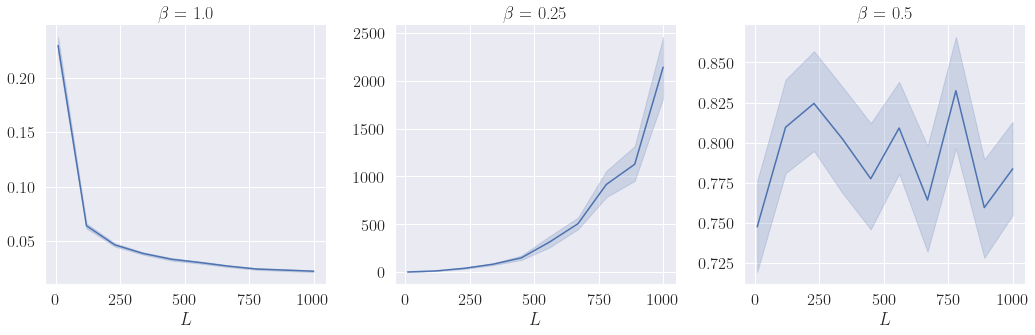

Evolution of the norm of the gradients as a function of L for different values of beta


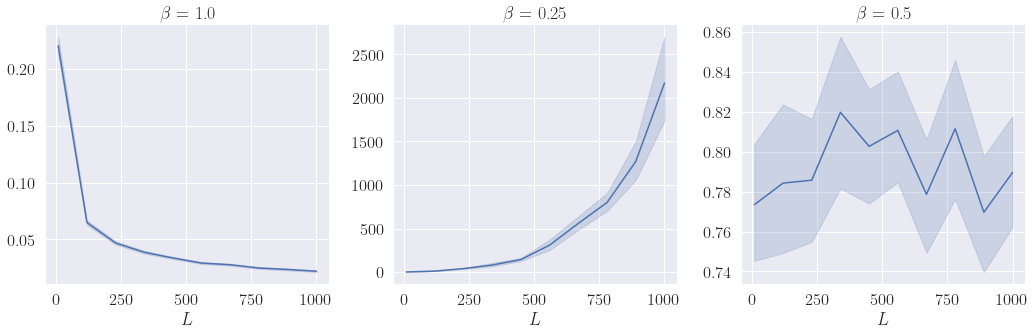

In [39]:
plot_results(results, grid_beta)

In [8]:
default_config['regularity']['type'] = 'rbf'
default_config['regularity']['value'] = 0.01
grid_beta = [2., 0.5, 1.]
results = run_experiment(default_config, grid_beta, grid_depth, niter, dim_input, nb_classes)

10
120
230
340
450
560
670
780
890
1000
10
120
230
340
450
560
670
780
890
1000
10
120
230
340
450
560
670
780
890
1000


Evolution of the norm of the output as a function of L for different values of beta


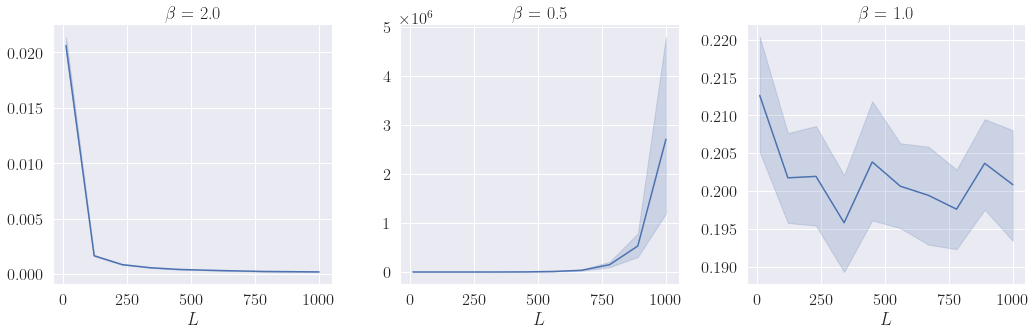

Evolution of the norm of the gradients as a function of L for different values of beta


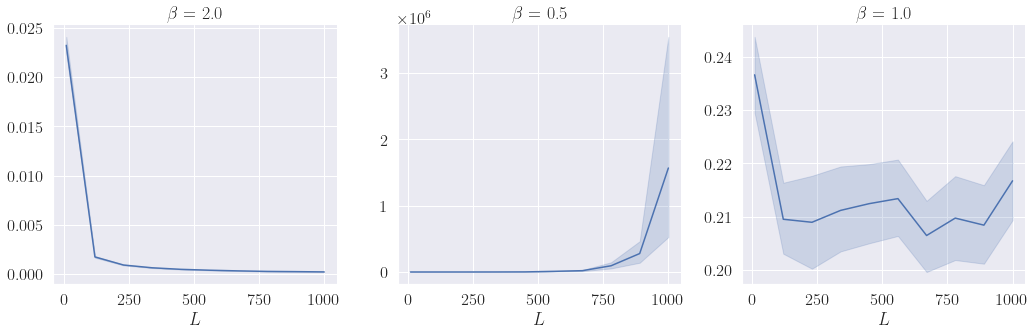

In [14]:
plot_results(results, grid_beta)

In [ ]:
model_config= {
    'width': 100,
    'activation': 'ReLU',
    'scaling_beta': 0.5,
    'regularity': {
        'type': 'iid'
    }
}
results = run_experiment(model_config, [0.5], [1000], 10**4, dim_input, nb_classes)

1000
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
